
### Helper Functions Section
Code adapted from: [Imanol Schlag](http://ischlag.github.io/2016/06/19/tensorflow-input-pipeline-example/)
and
[Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
### Skip to the main title: Colorectal Cancer Histology....

#### Preamble, load libraries

In [53]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random as rndm
from sklearn.metrics import confusion_matrix
from itertools import compress

#### Helper functions

In [139]:
# create a pipeline for reading the image files from disk
# and returning them with class labels
# image shape should be [height, width, num_channels]
def create_jpeg_pipeline(images, labels, onehots
                         , image_shape, batch_size
                         , shuffle):
    
    num_channels = image_shape[2]
    # create input queues
    # when called, this returns the next member of the Tensor
    input_queue = tf.train.slice_input_producer(
        [images, labels, onehots]
        , shuffle=shuffle
    )
    
    # take a path from the queue and read the file
    # take the class label in integer and one hot encoding at the same time
    file_content = tf.read_file(input_queue[0])
    image = tf.image.decode_jpeg(file_content, channels=num_channels)
    label = input_queue[1]
    onehot = input_queue[2]
    
    # define tensor shape for the image
    image.set_shape(image_shape)
    
    # collect batches of images before processing
    image_batch, label_batch, onehot_batch = tf.train.batch(
        [image, label, onehot]
        , batch_size=batch_size
    )
    
    return image_batch, label_batch, onehot_batch

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 4
    
    true_classes = [classes[idx] for idx in cls_true]
    if type(cls_pred) != type(None):
        pred_classes = [classes[idx] for idx in cls_pred]
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(image_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(true_classes[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(true_classes[i], pred_classes[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def test_accuracy(sess, test_batch
                  , show_example_errors=False,
                        show_confusion_matrix=False):

    # The whole test set will be run in a single batch
    # Create a feed-dict with these images and labels.
    feed_dict_test = {x: test_batch[0]
                  , y_true: test_batch[1]
                  , y_true_cls: test_batch[2]}
    
    # Calculate the predicted class using TensorFlow.
    cls_pred = sess.run(y_pred_cls, feed_dict=feed_dict_test)
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_pred == test_batch[2])

    # Calculate the number of correctly classified images.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / len(test_batch[2])

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, len(test_batch[2])))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:

        # Negate the boolean array.
        incorrect = (correct == False)
        # Get the images from the test-set that have been
        # incorrectly classified.
        incorrect_images = list(compress(test_batch[0], incorrect))
        incorrect_true = list(compress(test_batch[2], incorrect))
        incorrect_pred = list(compress(cls_pred, incorrect))
        
        # get 9 at random
        idx = np.random.choice([i for i in range(len(incorrect_true))], size=4, replace=False)
        
        images = [incorrect_images[i] for i in idx]
        true_cls = [incorrect_true[i] for i in idx]
        pred_cls = [incorrect_pred[i] for i in idx]
        
        print("Example errors:")
        plot_images(images=images,
                cls_true=true_cls,
                cls_pred=pred_cls)
        
    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
        
        

# runs the optimization in an active session
# pipeline is a list of tensors containing image queue, label queue and one hot queue
def optimize(sess, pipeline, num_iterations, silent = True):
    batches = [{} for i in range(num_iterations)]
    for i in range(num_iterations):
        # flatten the images to vectors
        next_img_batch = np.reshape(sess.run(pipeline[0]), (-1, image_size_flat), order='C')
        next_lab_batch = sess.run(pipeline[1])
        next_oho_batch = sess.run(pipeline[2])
        
      
        feed_dict_train = {x: next_img_batch,
                   y_true: next_oho_batch}
        
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i == 0:
            print("starting optimization routine:")
        if i == num_iterations - 1:
            print("ending optimization routine:")
        if not silent:
            print(sess.run(weights))
            print(sess.run(biases))

# Colorectal Cancer Histology Tissue Classification

Julian Hatwell

## Introduction

This project implements Tensorflow and the tf Layers API which has a good mix of usability while allowing access to inner structure.

The code used is based on the tutorials found here:
[Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials)

The images are released under [creative commons license](http://creativecommons.org/licenses/by/4.0/) and are available [here](https://zenodo.org/record/53169#.WS7OQuvyuUl)

#### Proof of concept with a simple linear model

#### Image Setup Parameters

In [54]:
# Colorectal Cancer Histology Tissue Images
# File Parameters
images_path = "\image_tiles_5000" # relative path

# routine to get image file paths and class labels
num_per_class = [] # will be 625 files in each of 8 classes
filenames = []
filefullpaths = []

for root, dirs, files in os.walk(os.getcwd() + images_path, topdown=False):
    if images_path in dirs:
        dirs.remove(images_path)
    if dirs:
        classes = dirs
    nfiles = 0
    for name in files:
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".jpg":
            nfiles += 1
            filenames.append(name)
            filefullpaths.append(os.path.join(root, name))
    if not dirs:
        num_per_class.append(nfiles)
        
num_images = len(filenames) # 5000
num_classes = len(classes) # 8

class_idx = np.empty([num_images], dtype=int) # 625 images of each type
for i in range(0, num_classes):
    class_idx[(i * num_per_class[i]):(i + 1) * num_per_class[i]] = i # class label indexes 0-7
        
class_labels = [classes[idx] for idx in class_idx]

#### Test Import One Image and assign the image size parameters

[150, 150, 3]
150 150 3
22500 67500


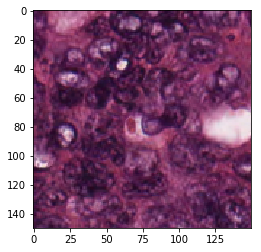

In [55]:
# Image Parameters
# First, load the image
dir_path = os.path.dirname(os.path.realpath('__file__'))
filename = dir_path + images_path + "\\01_TUMOR\\10009_CRC-Prim-HE-03_009.tif_Row_301_Col_151.jpg"

image = mpimg.imread(filename)


image_height, image_width, num_channels = image.shape
image_shape = [image_height, image_width, num_channels]
image_size = image_height * image_width # number of pixels
image_size_flat = image_size * num_channels # as a vector, number of bytes

# Print out its shape
print(image_shape)
print(image_height, image_width, num_channels)
print(image_size, image_size_flat)
plt.imshow(image)
plt.show()

#### Tensorflow graph parameters

In [56]:
# Processing Parameters
batch_size = 100
image_batch_shape = [batch_size, image_height, image_width, num_channels]
learning_rate = 0.01
training_epochs = 10

# create a partition vector for generating train and test
test_set_size = round(num_images * 0.1)

# set up two partitions
partitions = [0] * len(filefullpaths)
partitions[:test_set_size] = [1] * test_set_size
rndm.shuffle(partitions)

# Convert paths and labels to tensors
colorect_images = ops.convert_to_tensor(filefullpaths, dtype=dtypes.string)
colorect_labels = ops.convert_to_tensor(class_idx, dtype=dtypes.int32)
colorect_onehot = tf.one_hot(colorect_labels
                           , depth = 8
                           , on_value = 1
                           , off_value = 0)

# Partition into training and test
train_images, test_images = tf.dynamic_partition(colorect_images
                                                 , partitions, 2)
train_labels, test_labels = tf.dynamic_partition(colorect_labels
                                                 , partitions, 2)
train_onehot, test_onehot = tf.dynamic_partition(colorect_onehot
                                                 , partitions, 2)

#### Create training pipeline

In [57]:
# Using a helper function (above)
# The returned objects will get the next batch when called
train_img, train_lab, train_oho = create_jpeg_pipeline(train_images
                                                       , train_labels
                                                       , train_onehot
                                                       , image_shape
                                                       , batch_size=batch_size
                                                       , shuffle=True)

# create the test pipeline to deliver all the test images at once
test_img, test_lab, test_oho = create_jpeg_pipeline(test_images
                                                    , test_labels
                                                    , test_onehot
                                                    , image_shape
                                                    , batch_size=test_set_size
                                                    , shuffle=False)

#### Create the model graph, training and testing functions

In [58]:
# placeholders for the data inputs. None -> arbitrary batch size
x = tf.placeholder(tf.float32, [None, image_size_flat])
# x = tf.placeholder(tf.float32, image_batch_shape) will try this later
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

# variables for the weights / coefficients to be found
weights = tf.Variable(tf.zeros([image_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

# a linear model
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# an optimization routine
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#### Initialize and train the model

In [59]:
# this initializes the session
session = tf.Session()
session.run(tf.global_variables_initializer())

# initialize the queue threads that will import image batches
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord, sess=session)

In [149]:
# run the optimization, can repeat this step as many times
# and it will perform the backprop
optimize(session, [train_img, train_lab, train_oho], 10)

starting optimization routine:
ending optimization routine:


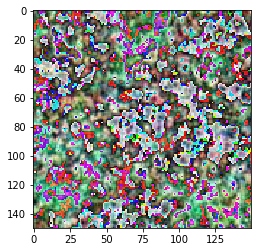

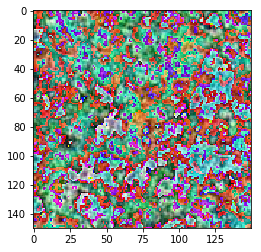

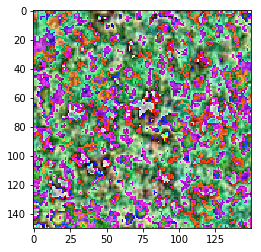

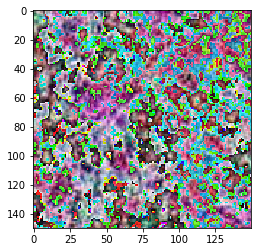

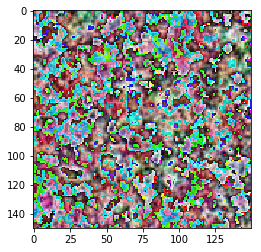

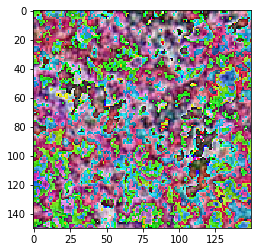

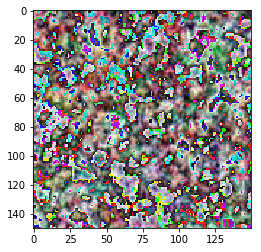

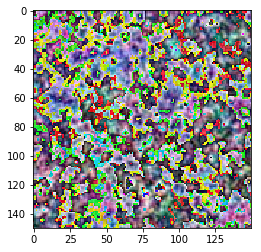

In [150]:
w = session.run(weights)
# print(w[0:6][0:6])
w1 = np.reshape(w, num_classes * image_size_flat
          , order='F'
          )
# print('reshaped:')
# print(w1[0:6])
# print(w1[67500:67505])
w2 = np.reshape(w1, (num_classes, image_height, image_width, num_channels)
          , order='C'
          )
# print('reshaped again:')
# print(w2[0][0][:2])
# print(w2[1][0][:2])
for i in range(num_classes):
    plt.imshow(w2[i])
    plt.show()

#### Test the model

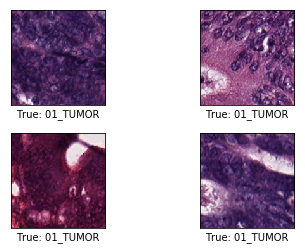

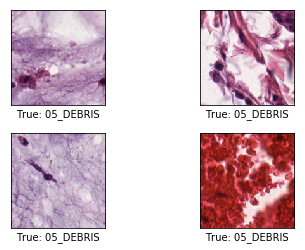

In [136]:
# show some examples, before running the test
plot_images(test_img_batch[0:4], test_lab_batch[0:4])

plot_images(test_img_batch[250:254], test_lab_batch[250:254])

Accuracy on Test-Set: 10.6% (53 / 500)
Example errors:


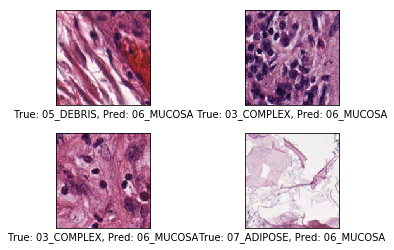

In [151]:
test_img_batch = np.reshape(session.run(test_img), (-1, image_size_flat), order='C')
test_oho_batch = session.run(test_oho)
test_lab_batch = session.run(test_lab)

test_batch = [test_img_batch, test_oho_batch, test_lab_batch]
test_accuracy(session, test_batch, show_example_errors = True)

#### Close the session

In [156]:
# tidy up threads
coord.request_stop()
coord.join(threads)

# close the session
session.close()

#### Creat a CNN Architecture

In [14]:
# Neural Network parameters
L1_filters = 4
L2_filters = 4

max_pooling = 2
down_samp1 = image_size//(max_pooling**2)
down_samp2 = image_size//(max_pooling**3)

# print(down_samp1, down_samp2)

FC_neurons = 16
OP_neurons = 8

The neural network built in this example will be based on the following architecture (source: [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/))

Each image is input to convolution layer one.
There are {{L1_filters}} filters in convolutional Layer one so it outputs {{L1_filters}} convolved images.

The images are then down-sampled with max-pooling. This decreases the resolution from {{image_size}} x {{image_size}} to {{down_samp1}} x {{down_samp1}}

The {{L1_filters}} new images are input to convolution layer two which has {{L2_filters}} filters per channel. So this outputs a total of {{L1_filters}} x {{L2_filters}} = {{L1_filters * L2_filters}} new colvolved images

The {{L1_filters * L2_filters}} are then downsampled, resulting in images of size {{down_samp2}} x {{down_samp2}}

Each image is then flattened to a vector of length {{down_samp2}} x {{down_samp2}} x {{L2_filters}}

Each vector is then input to a fully-connected hidden layer with {{FC_neurons}} neurons. This feeds another fully-connected layer with {{OP_neurons}} neurons, one for each of the classes.

Images are processed iteratively in random batches of {{batch_size}}

The numbers quoted do not match the following image but the architecture has the same flow.

![Flowchart](images/02_network_flowchart.png)